In [1]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

### jwst pipeline

In [35]:
import glob,os
import jwst
from astropy.io import fits
print(f'JWST version: {jwst.__version__}')

root_dir = '.'
filter_name = 'F090W'
inputfiles_level3_filter = glob.glob('jwstred_temp_dolphot/raw/*cal_err.fits')[:1]

JWST version: 1.14.0


In [36]:
inputfiles_level3_filter

['jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits']

In [26]:
#write out err file
hdu = fits.open(inputfiles_level3_filter[0])
err = hdu['ERR'].data
hdu['SCI'].data = err
hdu.writeto('jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits', overwrite = True)

In [37]:
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [38]:
input_images = inputfiles_level3_filter
table = input_list(input_images)
tables = organize_reduction_tables(table, byvisit=False)

In [39]:
table = table[(table['filter'] == 'f090w') | (table['filter'] == 'f150w')]
filter_name = 'f090w_f150w'

In [40]:
filter_name = table[0]['filter']

In [41]:
nircam_asn_file = f'jwstred_temp_dolphot/{filter_name}.json'
base_filenames = np.array([os.path.join('raw', os.path.basename(r['image'])) for r in table])
asn3 = asn_from_list.asn_from_list(base_filenames, 
    rule=DMS_Level3_Base, product_name=filter_name)

In [42]:
with open(nircam_asn_file, 'w') as outfile:
    name, serialized = asn3.dump(format='json')
    outfile.write(serialized)

In [43]:
print(asn3)

jwnoprogram-a3001_none_00003_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	f150w with 1 members


In [44]:
from jwst.pipeline import calwebb_image3
image3 = calwebb_image3.Image3Pipeline()

outdir_level3 = os.path.join('jwstred_temp_dolphot/', 'out_filter')
if not os.path.exists(outdir_level3):
    os.makedirs(outdir_level3)

image3.output_dir = outdir_level3
image3.save_results = True
image3.tweakreg.skip = True
image3.skymatch.skip = True
image3.skymatch.match_down = False
image3.source_catalog.skip = False
image3.resample.pixfrac = 0.8
# image3.resample.crpix = [1500, 1500]

image3.run(nircam_asn_file)

2024-11-05 18:50:53,729 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2024-11-05 18:50:53,731 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-11-05 18:50:53,735 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2024-11-05 18:50:53,737 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2024-11-05 18:50:53,739 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-11-05 18:50:53,741 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2024-11-05 18:50:53,742 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2024-11-05 18:50:53,851 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('jwstred_temp_dolphot/f150w.json',).
2024-11-05 18:50:53,858 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: 

In [48]:
#detection image
det_sci_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_sci.fits')
det_err_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_err.fits')
snr_dat = det_sci_hdu['SCI'].data/det_err_hdu['SCI'].data
det_sci_hdu['SCI'].data = snr_dat
det_sci_hdu.writeto('jwstred_temp_dolphot/out_filter/f150w_i2d_snr.fits')

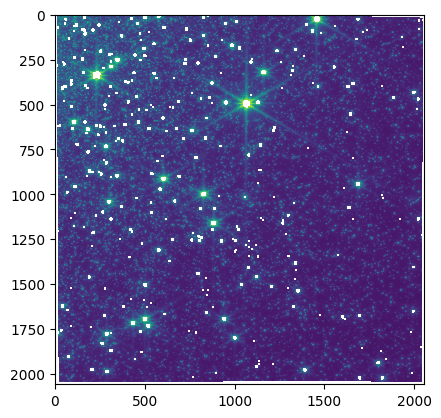

In [47]:
import matplotlib.pyplot as plt
plt.imshow(snr_dat)
plt.show()

### Multi-filter combine

In [2]:
import glob,os
import jwst
from astropy.io import fits
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
import shapely
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
f090_images = glob.glob('jwstred_temp_dolphot/jhat/*02101*fits')
f150_images = glob.glob('jwstred_temp_dolphot/jhat/*04101*fits')

In [5]:
#shapely polygons
pgons = []
for img in f150_images+f090_images:
    region = fits.getval(img, 'S_REGION', ext=1)
    coords = np.array(region.split('POLYGON ICRS  ')[1].split(' '), dtype = float)
    pgons.append(shapely.Polygon(coords.reshape(4, 2)))

In [6]:
#calculate net field
net_field = shapely.unary_union(pgons)

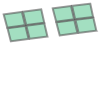

In [7]:
net_field

In [8]:
#collect edge points of the net field
points = []
for polygon in net_field.geoms:
    points.extend([list(i) for i in polygon.exterior.coords[:-1]])
points = np.array(points)

In [9]:
#find the bounds for the field
xmin, xmax, ymin, ymax = np.argmin(points[:, 0]), np.argmax(points[:, 0]), np.argmin(points[:, 1]), np.argmax(points[:, 1])

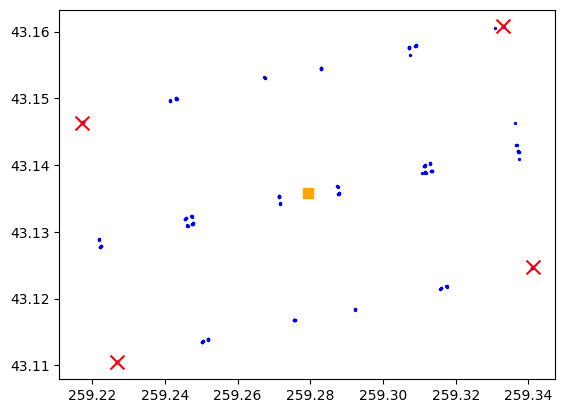

In [10]:
#plot the points and bounds
plt.scatter(points[:,0], points[:,1], marker = 'o', s = 2, color = 'blue')
plt.scatter(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], 
            marker = 'x', s = 100, color = 'red')
plt.scatter(net_field.centroid.x, net_field.centroid.y, marker = 's', color = 'orange', s = 50)
plt.show()

In [63]:
#create skycoord of the edge points
c=SkyCoord(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], unit = 'deg', frame = 'icrs')

In [81]:
#find the approximate bounding box dimensions of the field
#this calculation is done in (ra, dec) space so isn't the best way?
c[0].separation(c[2]).arcsec/0.031, c[0].separation(c[1]).arcsec/0.031

(4251.854867220238, 10811.275104119248)

In [75]:
#find bounding box dimesnions directly from the field
#kinda inaccurate since the field is rotated relative coordinate frame shapely assumes
(net_field.bounds[2] - net_field.bounds[0])*3600/0.031, (net_field.bounds[3] - net_field.bounds[1])*3600/0.031

(14407.468954837279, 5846.10979354902)

In [10]:
print(net_field.centroid)

POINT (259.2794680767732 43.135752140979484)


##### wcs check

In [3]:
from astropy import wcs
from gwcs import WCS as g_wcs

In [520]:
#read wcs for a single dither
hdu = fits.open('jwstred_temp_dolphot/jhat/jw01334001001_02101_00002_nrca3_jhat.fits')
sci_header = hdu['SCI'].header
w = wcs.WCS(sci_header)

In [540]:
#read wcs of the first mosaic and feed it to the second
#wcs for a long wavelength image can be "sliced" as wcs[::1/2, ::1/2] to make it short wavelength (i.e. double the resolution)
#(https://stackoverflow.com/questions/40475030/how-to-change-the-header-after-resizing-a-submap)
hdu = fits.open('jwstred_temp_dolphot/mosaic/f150w_i2d.fits')
sci_header = hdu['SCI'].header
w = wcs.WCS(sci_header)

In [4]:
from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u
from gwcs import coordinate_frames as cf

In [542]:
#convert wcs to gwcs using code from reference
#(#https://www.zonca.dev/posts/2020-09-10-wcs-astropy.html)

#rotation from matrix needs to be accounted for, otherwise the gwcs doesnt match original
#(https://gwcs.readthedocs.io/en/latest/gwcs/fits_analog.html)

shift_by_crpix = models.Shift(-(sci_header['CRPIX1'] - 1)) & models.Shift(-(sci_header['CRPIX2'] - 1))
matrix = np.array([[sci_header['PC1_1'], sci_header['PC1_2']],
                   [sci_header['PC2_1'] , sci_header['PC2_2']]])
rotation = models.AffineTransformation2D(matrix , translation=[0, 0])

tan = models.Pix2Sky_TAN()
#pixelscale transform needed because of how jwst pipeline writes this to file
#otherwise unit equivalencies are sufficient
pixelscale = models.Scale(sci_header['CDELT1']) & models.Scale(sci_header['CDELT2'])
celestial_rotation =  models.RotateNative2Celestial(sci_header['CRVAL1'], sci_header['CRVAL2'], 180)

det2sky = shift_by_crpix | rotation | pixelscale | tan | celestial_rotation
det2sky.name = "linear_transform"

detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(), name='icrs',
                              unit=(u.deg, u.deg))

pipeline = [(detector_frame, det2sky),
            (sky_frame, None)
           ]
wcsobj = g_wcs(pipeline)
wcsobj.bounding_box = ((0, sci_header['NAXIS1']), (0, sci_header['NAXIS2']))
print(wcsobj)

  From      Transform    
-------- ----------------
detector linear_transform
    icrs             None


In [543]:
#write gwcs to asdf file
from asdf import AsdfFile
tree = {"wcs": wcsobj}
wcs_file = AsdfFile(tree)
wcs_file.write_to("jwstred_temp_dolphot/mosaic_gwcs.asdf")

In [544]:
#convert pixel to world to compare wcs and gwcs
pixcrd = np.array([[0, 0], [0, sci_header['NAXIS2']],[sci_header['NAXIS1'], sci_header['NAXIS2']], [sci_header['NAXIS1'],0]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)

In [545]:
world, ((-world[0][0]+ world[-1][0]) * u.deg).to(u.arcsec), ((-world[0][1]+ world[1][1]) * u.deg).to(u.arcsec)

(array([[259.21625428,  43.14704548],
        [259.22530827,  43.10630486],
        [259.34496343,  43.12040371],
        [259.33598711,  43.16115373]]),
 <Quantity 431.03819579 arcsec>,
 <Quantity -146.6662389 arcsec>)

In [546]:
gwcs_crd = wcsobj(pixcrd[:,0], pixcrd[:,1], with_units=False)
gwcs_crd

(array([259.21625428, 259.22530827, 259.34496343, 259.33598711]),
 array([43.14704548, 43.10630486, 43.12040371, 43.16115373]))

In [547]:
wcsobj.forward_transform[3].factor

Parameter('factor', value=8.61111111111111e-06)

In [548]:
w.world_to_pixel(SkyCoord(259.22571932,  43.11027841, unit = 'deg', frame = 'icrs'))

(array(108.25408913), array(4343.08148411))

In [549]:
w.pixel_to_world(2000, 2000)

<SkyCoord (ICRS): (ra, dec) in deg
    (259.24332876, 43.13280066)>

In [550]:
wcsobj.pixel_to_world(2000, 2000)

<SkyCoord (ICRS): (ra, dec) in deg
    (259.24332876, 43.13280066)>

In [551]:
#change reference point to compare with dither wcs
w.wcs.crval = np.array([259.23102463946, 43.138970097072])
w.wcs.crpix = np.array([1024.5, 1024.5])

In [552]:
#pixel coordinates from dither wcs
w.world_to_pixel(sk_pts[0])

(array(2176.18902427), array(4193.96272756))

In [21]:
#skycoord of points
sk_pts = SkyCoord(points[:,0], points[:,1], frame = 'icrs', unit = 'deg')

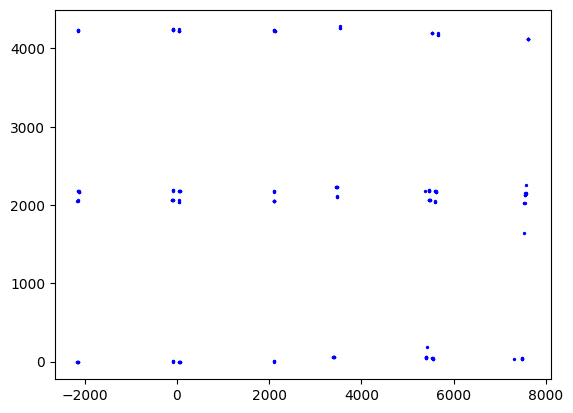

In [526]:
#convert from ra, dec to pixel coordinates
cvt = w.all_world2pix(points, 0)
plt.scatter(cvt[:,0], cvt[:,1], marker = 'o', s = 2, color = 'blue')
# plt.scatter(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], 
#             marker = 'x', s = 100, color = 'red')
# plt.scatter(net_field.centroid.x, net_field.centroid.y, marker = 's', color = 'orange', s = 50)
plt.show()

In [527]:
max(cvt[:, 0]) - min(cvt[:, 0]), max(cvt[:, 1]) - min(cvt[:, 1])

(9775.040118953975, 4293.376990848344)

#### mosaic

In [553]:
#create mosaic
root_dir = '.'
filter_name = 'F090W'

In [554]:
input_images = f090_images
table = input_list(input_images)
tables = organize_reduction_tables(table, byvisit=False)
filter_name = table[0]['filter']

In [555]:
nircam_asn_file = f'jwstred_temp_dolphot/jhat/{filter_name}_c.json'
base_filenames = np.array([os.path.basename(r['image']) for r in table])
asn3 = asn_from_list.asn_from_list(base_filenames, 
    rule=DMS_Level3_Base, product_name=filter_name)

In [556]:
with open(nircam_asn_file, 'w') as outfile:
    name, serialized = asn3.dump(format='json')
    outfile.write(serialized)

In [557]:
print(asn3)

jwnoprogram-a3001_none_00007_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	f090w with 32 members


In [558]:
from jwst.pipeline import calwebb_image3
image3 = calwebb_image3.Image3Pipeline()

outdir_level3 = os.path.join('jwstred_temp_dolphot/', 'mosaic')
if not os.path.exists(outdir_level3):
    os.makedirs(outdir_level3)

image3.output_dir = outdir_level3
image3.save_results = True
image3.tweakreg.skip = True
# image3.skymatch.skip = True
# image3.skymatch.match_down = False
image3.skymatch.skymethod = 'local'
image3.skymatch.match_down = False
image3.source_catalog.skip = False

image3.resample.pixfrac = 1.0
image3.resample.kernel = 'gaussian'
# image3.resample.pixel_scale = 0.031
# image3.resample.crval = (net_field.centroid.x , net_field.centroid.y)
# image3.resample.output_shape = (int(max(cvt[:, 0]) - min(cvt[:, 0]) + 500), int(max(cvt[:, 1]) - min(cvt[:, 1]) + 500))

# image3.resample.output_shape = (sci_header['NAXIS1'], sci_header['NAXIS2'])
image3.resample.output_wcs = 'jwstred_temp_dolphot/mosaic_gwcs.asdf'
image3.run(nircam_asn_file)

2025-01-27 23:46:27,828 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2025-01-27 23:46:27,830 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-01-27 23:46:27,834 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2025-01-27 23:46:27,835 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2025-01-27 23:46:27,836 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-01-27 23:46:27,837 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2025-01-27 23:46:27,839 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2025-01-27 23:46:28,278 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('jwstred_temp_dolphot/jhat/f090w_c.json',).
2025-01-27 23:46:28,284 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  outpu

#### psf matching

In [180]:
import webbpsf
from astropy.stats import sigma_clipped_stats as scs
from photutils.psf.matching import resize_psf, SplitCosineBellWindow, create_matching_kernel, CosineBellWindow, TukeyWindow, TopHatWindow, HanningWindow
from astropy.convolution import convolve, convolve_fft
import matplotlib as mpl

In [181]:
#generate psfs with size 161 px x 161 px (dimensions need to be odd)
#oversampled psf is not used, the last extension with detector scale psf + distortion is used for convolution
ovs, fov = 5, 81
nrc = webbpsf.NIRCam()
nrc.filter = 'F115W'
nrc.detector = 'NRCA3'
psf_f090 = nrc.calc_psf(oversample=ovs, fov_pixels=fov) 

In [182]:
nrc.filter =  'F200W'
psf_f150 = nrc.calc_psf(oversample=ovs, fov_pixels=fov) 

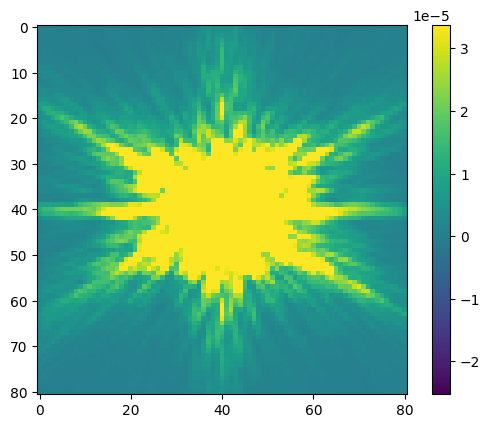

In [183]:
psf_dat = psf_f090[3].data 
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
# plt.imshow(psf_dat, norm = 'log')
plt.colorbar()
plt.show()

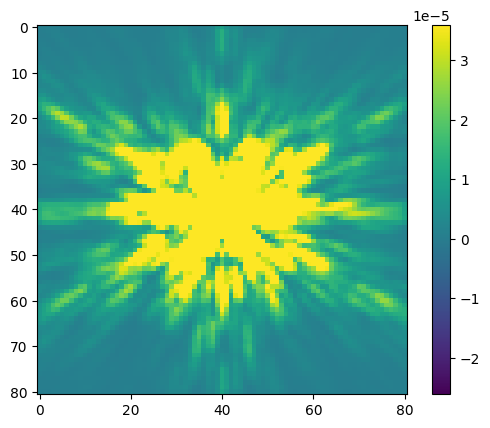

In [184]:
psf_dat = psf_f150[3].data
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
# plt.imshow(psf_dat, norm = 'log')
plt.colorbar()
plt.show()

In [185]:
#generate the matching kernel to convert the f090w image to f150w
#dolphot custom psf is still for single filter, so cross-convolution wouldnt work
#the values of alpha and beta are in the window very important, below beta ~1.3 a ringing is present in the matching kernel
reference_PSF = psf_f150[3].data
psfim = psf_f090[3].data

window = SplitCosineBellWindow(1.5, 1.3)
PSF_kernel = create_matching_kernel(psfim, reference_PSF, window=window) #image to be convolved goes first, then reference

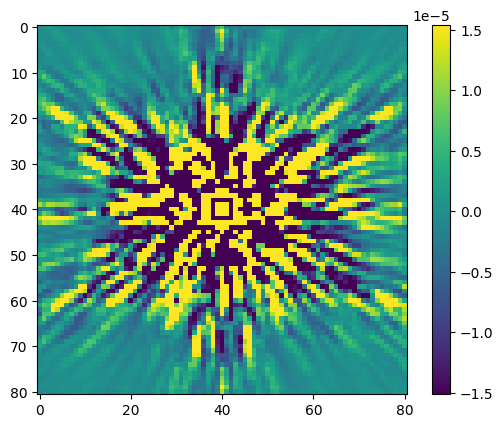

In [186]:
psf_dat = PSF_kernel
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 1*pstd, vmax = pmed + 1*pstd)
plt.colorbar()
plt.show()

In [187]:
#### convolve the psf
conpsf = convolve_fft(psfim, PSF_kernel, normalize_kernel=True)

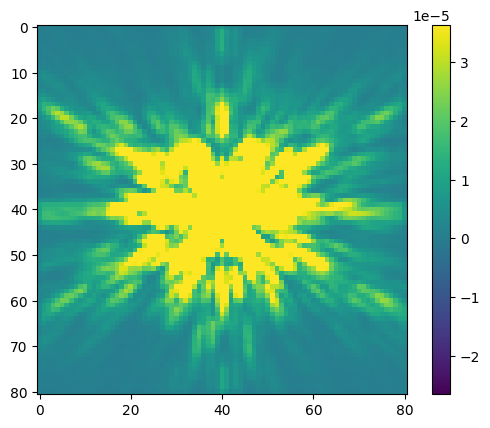

In [188]:
#difference between convolved psf and f150w psf is ~10**(-8) (2-3%)
psf_dat = conpsf 
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
# plt.imshow(psf_dat, norm = 'log')
plt.colorbar()
plt.show()

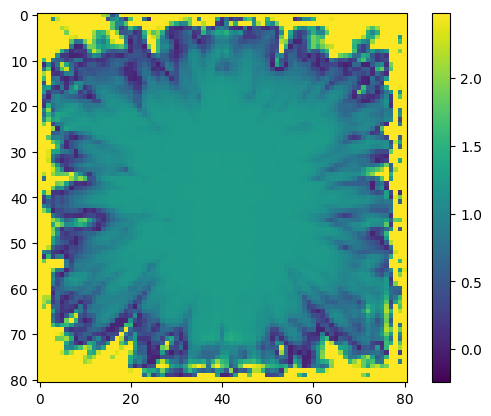

In [189]:
psf_dat = np.abs((conpsf - psf_f150[3].data)/psf_f150[3].data * 100)
# psf_dat = conpsf 
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
# plt.imshow(psf_dat, norm = 'log')
plt.colorbar()
plt.show()

In [259]:
refimage = fits.open('jwstred_temp_dolphot/mosaic/f115w_i2d.fits')
# refimage = fits.open('jwstred_temp_dolphot/jhat/jw01334001001_02101_00001_nrcb3_jhat.fits')
reference_image_data = refimage[1].data
reference_image_err = refimage[2].data

In [260]:
mask = reference_image_data==0

In [261]:
#convolve using convolve_fft as it is much faster than convolve
convolved_image = convolve_fft(reference_image_data, PSF_kernel, normalize_kernel=True, allow_huge = True)
convolved_err = convolve_fft(reference_image_err, PSF_kernel, normalize_kernel=True, allow_huge = True)

In [262]:
convolved_wht = convolve_fft(refimage['WHT'].data, PSF_kernel, normalize_kernel=True, allow_huge=True)

In [264]:
convolved_image, convolved_err = convolved_image*(3.10225/1.946125), convolved_err*(3.10225/1.946125)
convolved_wht = convolved_image*(3.10225/1.946125)

In [265]:
convolved_image[mask] = 0
convolved_err[mask] = 0
convolved_wht[mask] = 0

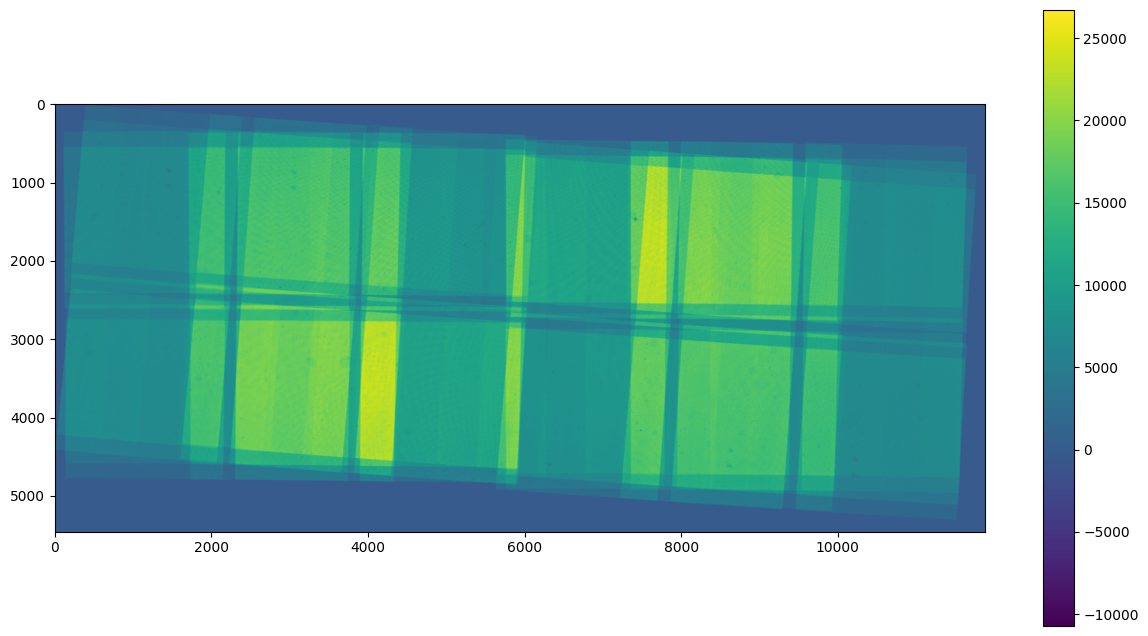

In [263]:
psf_dat = convolved_wht
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

In [266]:
refimage[1].data = convolved_image
refimage[2].data = convolved_err
refimage['WHT'].data = convolved_wht

In [267]:
refimage.writeto('jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits', overwrite = True)

In [607]:
from tqdm import tqdm

In [609]:
for im in tqdm(f090_images):
    refimage = fits.open(im)
    reference_image_data = refimage[1].data
    convolved_image = convolve_fft(reference_image_data, PSF_kernel, normalize_kernel=True)
    refimage[1].data = convolved_image
    refimage.writeto(im.replace('jhat', 'mosaic'), overwrite = True)

100%|███████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]


In [625]:
for im in f090_images_mosaic:
    with fits.open(im, mode='update') as filehandle:
        filehandle[0].header['Filter'] = "F150W"

#### coadd

In [214]:
from astropy import units as u
from astropy.nddata import CCDData
from astropy import nddata
from ccdproc import Combiner

In [215]:
def create_ccddata(file):
    hdu = fits.open(file)
    sci_data = hdu['SCI'].data
    
    uncertainty = nddata.StdDevUncertainty(array = hdu['ERR'].data)
    data_unit = u.MJy/u.sr
    w = wcs.WCS(hdu['SCI'].header)
    mask = sci_data == 0
    ccd_data = CCDData(data = sci_data, uncertainty = uncertainty, 
                       wcs = w, unit = u.MJy/u.sr)
    
    return ccd_data

In [216]:
def update_photmjsr(ccddata, phots):
    ccd_mjsr = np.sum([ccd.data for ccd in ccddata], axis = 0)
    ccd_cps = np.sum([ccd.data/phot for ccd, phot in list(zip(ccddata, phots))], axis = 0)
    mjsr = ccd_mjsr/ccd_cps
    _, mjsr_med, _ = scs(mjsr)

    return mjsr_med

In [268]:
fwhm_dict = {'F090W': 1.065, 'F150W': 1.613}
exptime_dict = {'jwstred_temp_dolphot/mosaic/ngc628_f150w_con_f200w.fits': 1717, 
           'jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits': 5153, 
           'jwstred_temp_dolphot/mosaic/f200w_i2d.fits': 7215}

In [314]:
def coadd(ref_files, filt, filename = 'jwstred_temp_dolphot/mosaic/coadd_i2d.fits'):
    #edit specific header keys
    hdu_template = fits.open(ref_files[0])
    hdr_update = {'EFFEXPTM': 0, 'TMEASURE': 0, 'DURATION': 0}
    filters, phots = [], []
    #WHT data for coadded image
    wht_data = []
    # combiner_weights = []
    
    for file in ref_files:
        hdu_ = fits.open(file)
        for key in list(hdr_update.keys()):
            hdr_update[key] += fits.getval(file, key, ext = 0)
        flt_ = fits.getval(file, 'FILTER', ext = 0)
        filters.append(flt_)
        phots.append(fits.getval(file, 'PHOTMJSR', ext = 1))
        # #inverse variance weighting
        # wht_data.append(hdu_['WHT'].data/exptime_dict[file])
        wht_data.append((1/hdu_['ERR'].data**2)/exptime_dict[file])

        # snr weighting
        # wht_data.append(np.sqrt(hdu_['SCI'].data/hdu_['ERR'].data))
        
        # zp_data.append(zp_dict[file])
        # combiner_weights.append(1/fwhm_dict[flt_]**2)
        hdu_.close()

    combiner_weights = np.array(wht_data)
    combiner_weights /= np.sum(combiner_weights, axis = 0)
    
    # combiner_weights /= np.sqrt(np.sum([zp*w for zp, w in zip(zp_data, combiner_weights)], axis = 0))

    for i, wt_ in enumerate(combiner_weights):
        mask_ = np.isnan(wt_) | np.isinf(wt_)
        wt_[mask_] = 0
        combiner_weights[i] = wt_ 
    combiner_weights = np.array(combiner_weights)
    # combiner_weights = np.array([1889, 5840])/(1889+5840)
    
    #coadd images using ccdproc
    ccddata_ = []
    for file in ref_files:
        ccddata_.append(create_ccddata(file))
        
    combiner = Combiner(ccddata_)
    combiner.weights = combiner_weights
    combined_sum = combiner.sum_combine()

    #SCI and ERR data for coadded image
    coadd_data = combined_sum.data
    det_mask = coadd_data == 0
    # quad_err = np.sqrt(np.sum([ccd.uncertainty.array**2 for ccd in ccddata_], axis = 0))
    quad_err = np.sqrt(np.sum([(wht_*ccd.uncertainty.array)**2 for ccd, wht_ in zip(ccddata_, combiner_weights)], axis = 0))
        
    primary_header, sci_header = hdu_template['PRIMARY'].header, hdu_template['SCI'].header
    err_header, wht_header = hdu_template['ERR'].header, hdu_template['WHT'].header
    primary_header['FILENAME'] = 'ngc628_coadd3_i2d.fits'
    primary_header['FILTER'] = filt
    for key in list(hdr_update.keys()):
        primary_header[key] = hdr_update[key]

    sci_header['PHOTMJSR'] = update_photmjsr(ccddata_, phots)
    sci_header['XPOSURE'] = hdr_update['EFFEXPTM']
    sci_header['TELAPSE'] = hdr_update['DURATION']

    # snr_data = coadd_data/quad_err
    # snr_data[np.isnan(snr_data)] = 0.0

    primary_hdu = fits.PrimaryHDU(header = primary_header)
    sci_hdu = fits.ImageHDU(data = coadd_data, header = sci_header, name = 'SCI')
    err_hdu = fits.ImageHDU(data = quad_err, header = err_header, name = 'ERR')
    wht_hdu = fits.ImageHDU(data = np.sum(wht_data, axis = 0), header = wht_header, name = 'WHT')
    
    coadd_hdul = fits.HDUList([primary_hdu, sci_hdu, err_hdu, wht_hdu])
    coadd_hdul.writeto(filename, overwrite = True)
    hdu_template.close()

    return coadd_data, combiner_weights

In [315]:
# ref_files = ['jwstred_temp_dolphot/mosaic/f150w_i2d.fits', 'jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f150w.fits']
# ref_files = ['jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits', 'jwstred_temp_dolphot/mosaic/ngc628_f150w_con_f200w.fits', 
#              'jwstred_temp_dolphot/mosaic/f200w_i2d.fits']
ref_files = ['jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits',
             'jwstred_temp_dolphot/mosaic/f200w_i2d.fits']

####  ccdcombine

In [278]:
wht_data = []

for file in ref_files:
    hdu_ = fits.open(file)
    # #inverse variance weighting
    # wht_data.append(hdu_['WHT'].data/exptime_dict[file])
    wht_data.append(1/hdu_['ERR'].data**2)
    hdu_.close()

combiner_weights = np.array(wht_data)
combiner_weights /= np.sum(combiner_weights, axis = 0)

for i, wt_ in enumerate(combiner_weights):
    mask_ = np.isnan(wt_) | np.isinf(wt_)
    wt_[mask_] = 0
    combiner_weights[i] = wt_ 
combiner_weights = np.array(combiner_weights)

In [279]:
#coadd images using ccdproc
ccddata_ = []
for file in ref_files:
    ccddata_.append(create_ccddata(file))
    
combiner = Combiner(ccddata_)
combiner.weights = combiner_weights
combined_sum = combiner.sum_combine()

#SCI and ERR data for coadded image
coadd_data = combined_sum.data
det_mask = coadd_data == 0
# quad_err = np.sqrt(np.sum([ccd.uncertainty.array**2 for ccd in ccddata_], axis = 0))
quad_err = np.sqrt(np.sum([(wht_*ccd.uncertainty.array)**2 for ccd, wht_ in zip(ccddata_, combiner_weights)], axis = 0))

In [280]:
i1, i2 = 3983, 9740
coadd_data[i1, i2]

1.2159989319802582

In [281]:
ccddata_[0].data[i1, i2], ccddata_[1].data[i1, i2]

(1.565051628602576, 1.1377302)

In [282]:
hdu1, hdu2 = fits.open(ref_files[0]), fits.open(ref_files[1])
sci1, sci2 = hdu1[1].data, hdu2[1].data
err1, err2 = hdu1[2].data, hdu2[2].data

In [283]:
combiner_weights[0][i1, i2], combiner_weights[1][i1, i2]

(0.18316118358807776, 0.8168388164119222)

In [284]:
combiner_weights[0][i1, i2]*ccddata_[0].data[i1, i2] + combiner_weights[1][i1, i2]*ccddata_[1].data[i1, i2] 

1.2159989319802582

In [285]:
coadd_data_chk = combiner_weights[0]*sci1 + combiner_weights[1]*sci2

In [286]:
sci1[i1, i2], sci2[i1, i2], coadd_data_chk[i1, i2]

(1.565051628602576, 1.1377302, 1.2159989319802582)

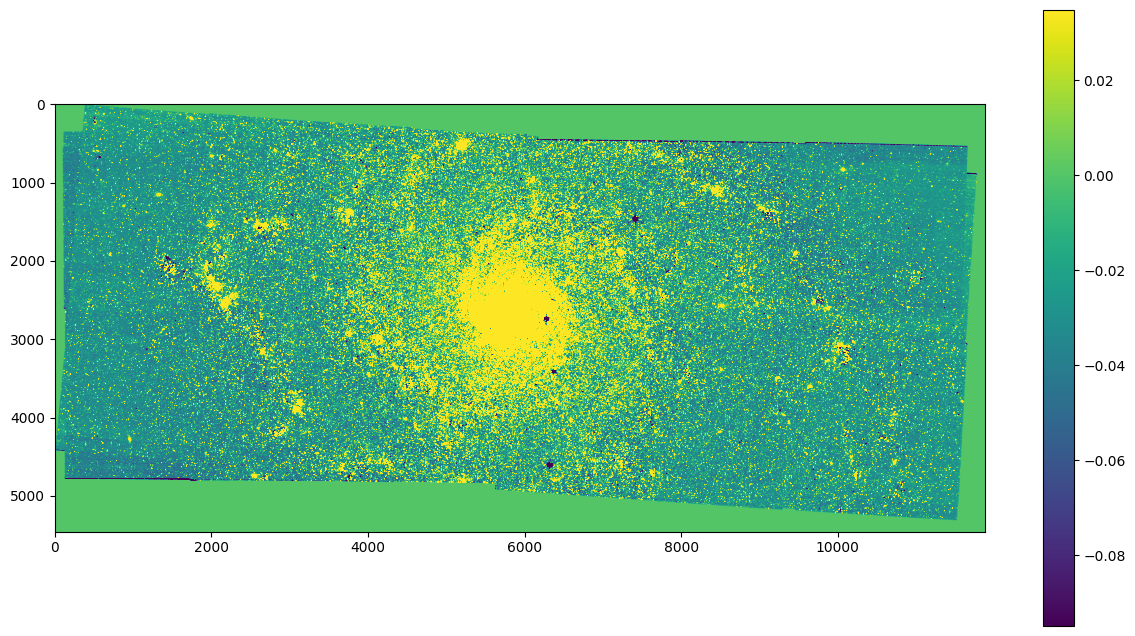

In [111]:
data = sci2 - coadd_data_chk
# data[data > 0] = np.nan
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

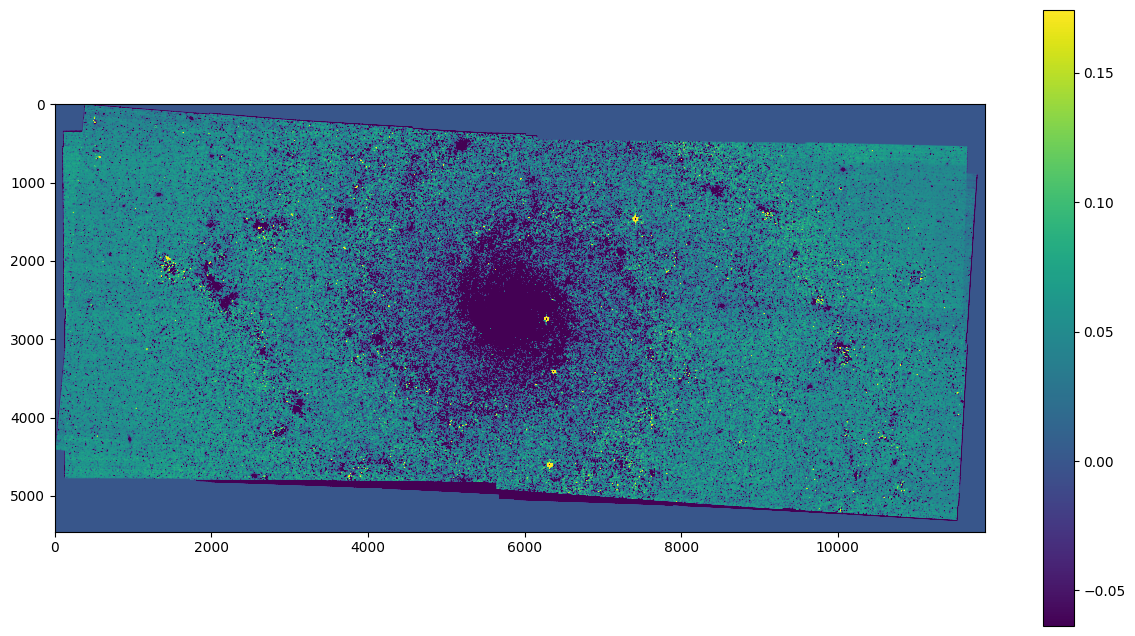

In [113]:
data = sci1 - coadd_data_chk
# data[data > 0] = np.nan
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

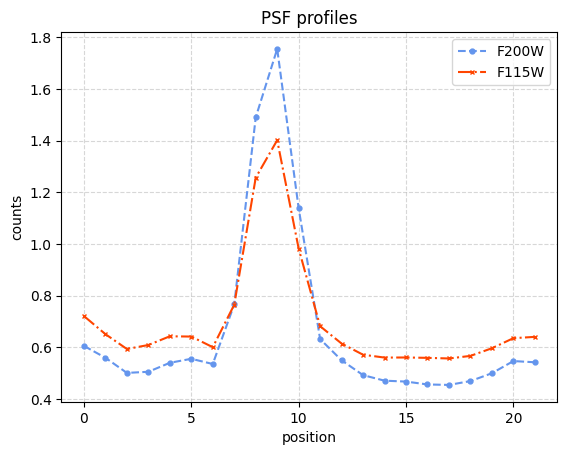

In [132]:
idy1, idy2 = 9730, 9752
idx1 = 3983
psf1 = sci2[idx1, idy1:idy2]
psf2 = sci1[idx1, idy1:idy2]
# psf3 = im3['SCI'].data[idx1, idy1:idy2]
# psf4 = im4['SCI'].data[idx1, idy1:idy2]
plt.plot(psf1, color = 'cornflowerblue', marker = 'o', ls = '--', markersize = 3.5, label = 'F200W')
plt.plot(psf2, color = 'orangered', marker = 'x', ls = '-.', markersize = 3.5, label = 'F115W')
# plt.plot(psf3, color = 'royalblue', marker = 's', ls = ':', markersize = 3.5, label = 'Coadd')
plt.legend()
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('position')
plt.ylabel('counts')
# plt.yscale('log')
plt.title('PSF profiles')
# plt.xlim(15, 20)
# plt.xlim(31, 36)
plt.show()

In [179]:
data.min()

-324.64397341261224

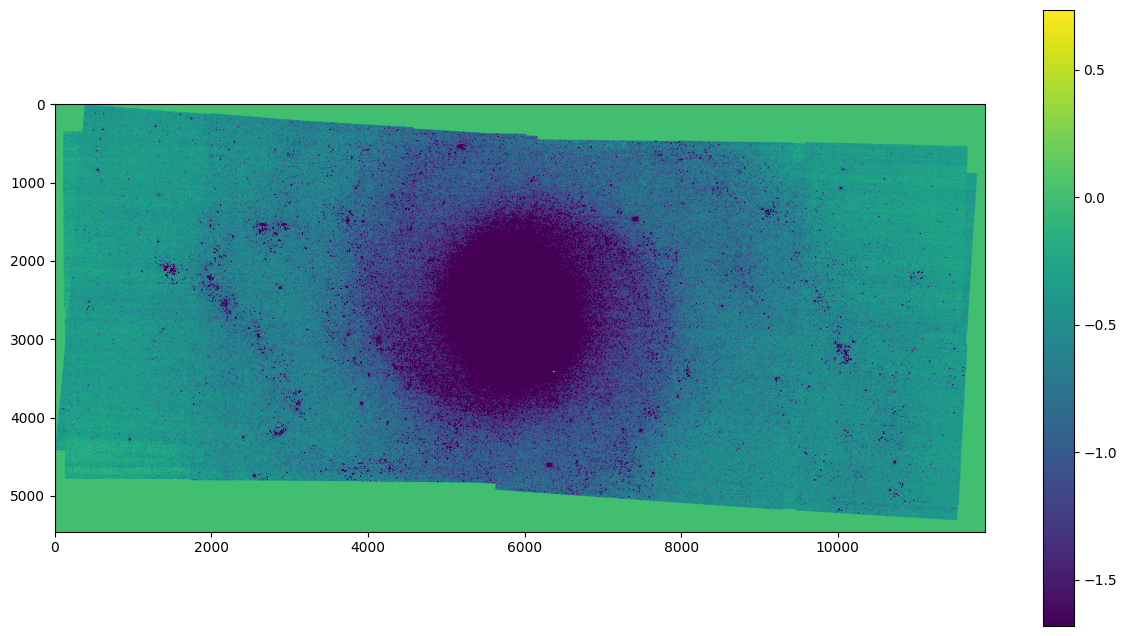

In [211]:
im1 = fits.open('jwstred_temp_dolphot/mosaic/f115w_i2d.fits')
im2 = fits.open('jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits')

data = im1[1].data - im2[1].data
# data[data > 0] = np.nan
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

#### ccdcombine

In [316]:
coadd_data = coadd(ref_files, 'F200W', filename = 'jwstred_temp_dolphot/mosaic/ngc628_coadd3_i2d.fits')

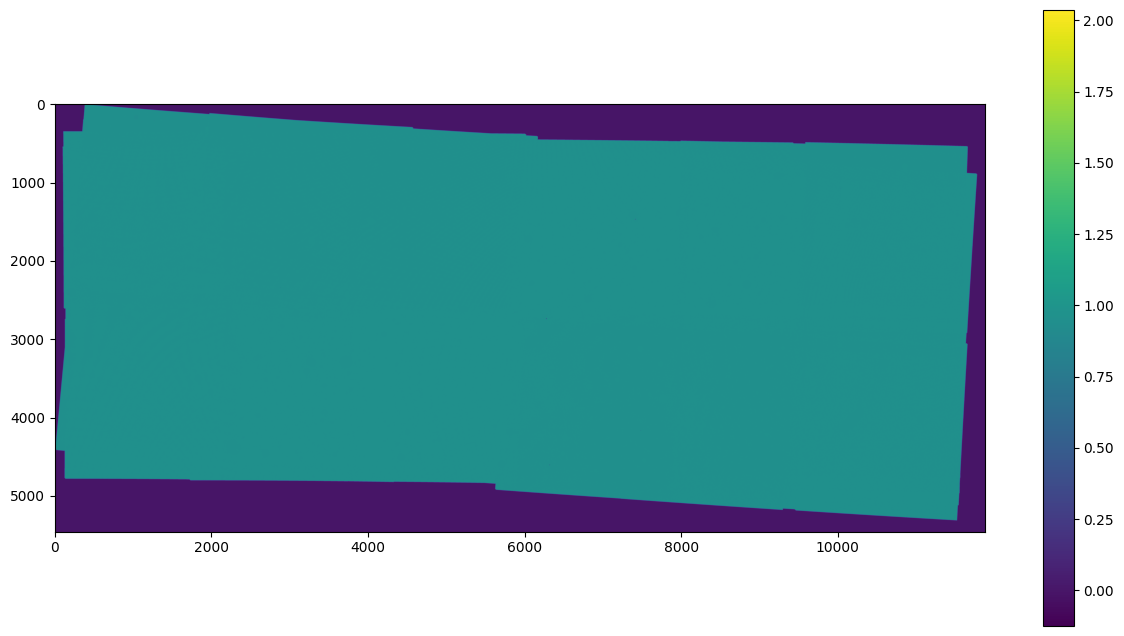

In [184]:
data = wt2
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

In [300]:
ccd1 = create_ccddata('jwstred_temp_dolphot/mosaic/f200w_i2d.fits')
wht1 = fits.open('jwstred_temp_dolphot/mosaic/f200w_i2d.fits')['WHT'].data
ccd2 = create_ccddata('jwstred_temp_dolphot/mosaic/ngc628_coadd3_i2d.fits')
wht2 = fits.open('jwstred_temp_dolphot/mosaic/ngc628_coadd3_i2d.fits')['WHT'].data

In [113]:
quad_err = np.sqrt((ccd1.uncertainty.array**2) + (ccd2.uncertainty.array**2))

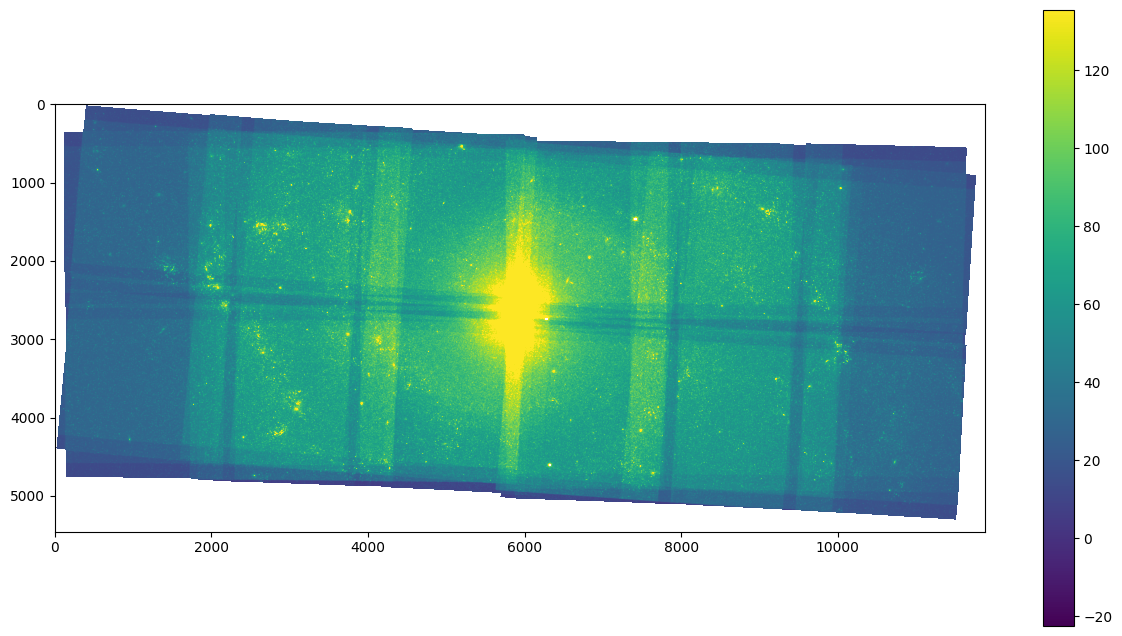

In [301]:
data = ccd1.data/ccd1.uncertainty.array
# data[data < 0] = np.nan
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

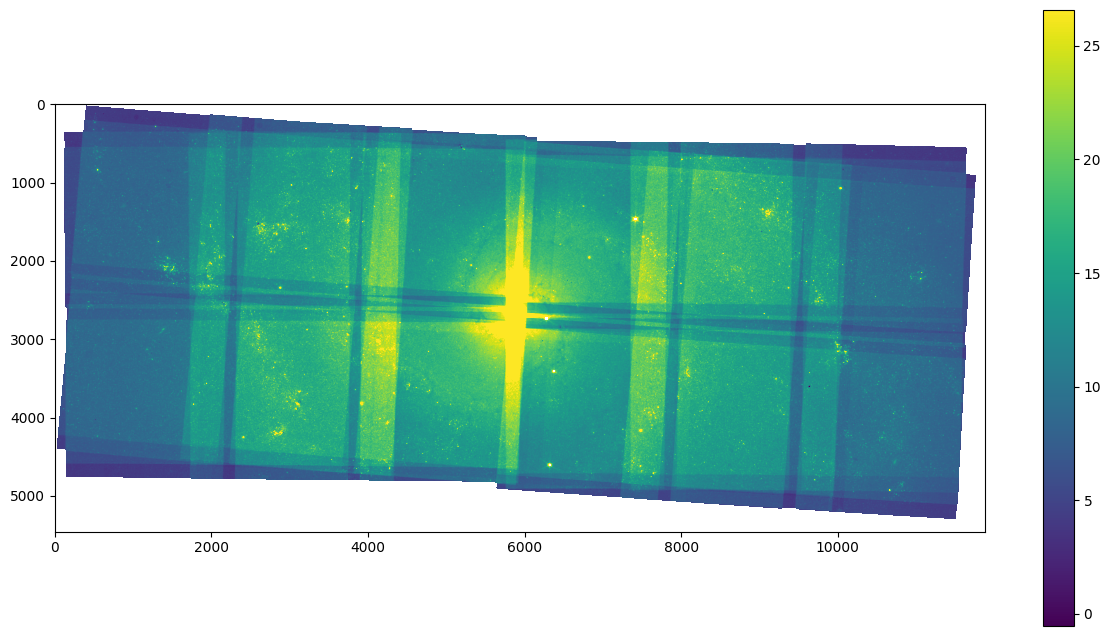

In [302]:
data = -ccd1.data/ccd1.uncertainty.array + ccd2.data/ccd2.uncertainty.array
_, pmed, pstd = scs(data, sigma = 3.0)
plt.figure(figsize = (15, 8))
plt.imshow(data, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.colorbar()
plt.show()

In [46]:
normwht1 = wht1/(wht1+wht2)
n1_mask = np.isnan(normwht1) | np.isinf(normwht1)
normwht1[n1_mask] = 0

normwht2 = wht2/(wht1+wht2)
n2_mask = np.isnan(normwht2) | np.isinf(normwht2)
normwht2[n2_mask] = 0

In [53]:
combiner = Combiner([ccd1, ccd2])
combiner.weights = np.array([normwht1, normwht2])
combined_average = combiner.sum_combine()
# combined_average.uncertainty.arrray = quad_err

In [96]:
#tmp
import pandas as pd
df1 = pd.read_csv('jwstred_temp_dolphot/coadd_dolphot/ngc628_coadd2.phot', sep = '\s+', header = None)
df2 = pd.read_csv('jwstred_temp_dolphot/coadd_dolphot/ngc628_coadd_f200_fitsky2.phot', sep = '\s+', header = None)

In [97]:
cuts1 = (df1[5] >= 5) & ((df1[6])**2 <= 0.01) & (df1[9] <= 0.5) & (df1[10] <=2)
cuts2 = (df2[5] >= 5) & ((df2[6])**2 <= 0.01) & (df2[9] <= 0.5) & (df2[10] <=2)

In [98]:
df1 = df1[cuts1]
df1_idx = ["{:.2f}_{:.2f}".format(i, j) for i, j in zip(np.floor(np.array(df1[2])), np.floor(np.array(df1[3])))]
df1['idx'] = df1_idx
df1.set_index('idx', inplace = True)

In [99]:
df2 = df2[cuts2]
df2_idx = ["{:.2f}_{:.2f}".format(i, j) for i, j in zip(np.floor(np.array(df2[2])), np.floor(np.array(df2[3])))]
df2['idx'] = df2_idx
df2.set_index('idx', inplace = True)

In [104]:
len(df1), len(df2)

(234897, 234517)

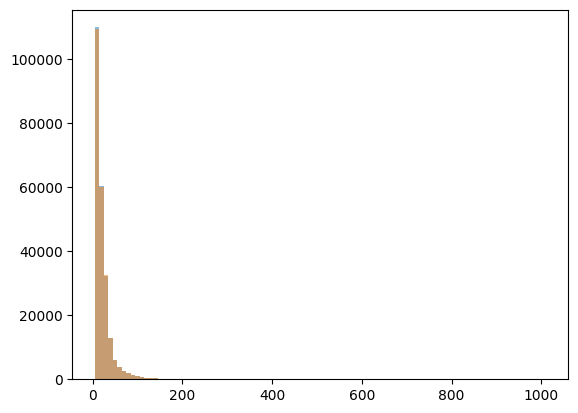

In [101]:
plt.hist(df1[5], bins = 100, alpha = 0.5)
plt.hist(df2[5], bins = 100, alpha = 0.5)
# plt.yscale('log')
plt.show()

In [102]:
df1[15]/df1[17], df1[5]

(idx
 6365.00_3409.00       10.000900
 6274.00_2739.00       10.000900
 7476.00_4163.00    17105.000000
 2874.00_2341.00       10.000900
 5311.00_2054.00     9065.000000
                        ...     
 2478.00_838.00       119.836207
 2070.00_1002.00      113.832653
 3454.00_2180.00      122.986667
 2540.00_639.00       120.242424
 2089.00_2422.00      259.417476
 Length: 234897, dtype: float64,
 idx
 6365.00_3409.00     336.3
 6274.00_2739.00     166.5
 7476.00_4163.00     773.3
 2874.00_2341.00    1010.2
 5311.00_2054.00     702.7
                     ...  
 2478.00_838.00        5.0
 2070.00_1002.00       5.1
 3454.00_2180.00       5.2
 2540.00_639.00        5.1
 2089.00_2422.00      10.7
 Name: 5, Length: 234897, dtype: float64)

In [73]:
def lin(x, m, c):
    return m*x + c

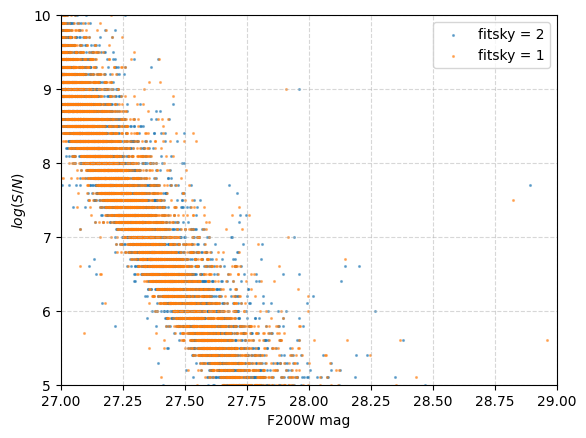

In [148]:
plt.scatter(df1[15][df1[15] != 99.999], df1[5][df1[15] != 99.999], s = 1.5, alpha = 0.5, label = 'fitsky = 2')
plt.scatter(df2[15][df2[15] != 99.999], df2[5][df2[15] != 99.999], s = 1.5, alpha = 0.5, label = 'fitsky = 1')
# plt.plot(np.linspace(18, 30, 10), lin(np.linspace(18, 30, 10), -0.245, 7.5))
plt.xlim(27, 29)
plt.ylim(5, 10)
plt.grid(alpha = 0.5, linestyle = '--')
plt.xlabel('F200W mag')
plt.ylabel(r'$log(S/N)$')
plt.legend()
plt.show()

In [69]:
np.savetxt('fitsky2.txt', df1[df1[5] >10][[2, 3]].values, fmt='%s')
np.savetxt('fitsky1.txt', df2[df2[5] >10][[2, 3]].values, fmt='%s')

In [105]:
df_fake = pd.read_csv('jwstred_temp_dolphot/coadd_dolphot/NGC628_ast.fake', sep = '\s+', header = None)

In [108]:
inputlist = pd.read_csv('jwstred_temp_dolphot/coadd_dolphot/NGC628_fake.inputlist', sep = '\s+', header = None)

In [111]:
(inputlist[5] > 28).sum()

6510

In [106]:
df_fake

0   1        2        3        4       5        6       7         8   \
0       1   1   386.98    55.65     13.1  29.283      6.8  29.283      12.6   
1       1   1   480.62    45.03   1090.5  24.485    562.0  24.485    9176.0   
2       1   1   453.63    49.21    196.6  26.345    101.3  26.345     428.8   
3       1   1   579.63    58.38    573.9  25.182    295.8  25.182    2515.7   
4       1   1   667.45    62.04    256.1  26.058    132.0  26.058     319.0   
...    ..  ..      ...      ...      ...     ...      ...     ...       ...   
11879   1   1  7256.10  4888.17    299.2  25.889    154.2  25.889     471.5   
11880   1   1  7349.15  4891.97    114.1  26.936     58.8  26.936     375.9   
11881   1   1  7520.95  4886.83    491.6  25.350    253.4  25.350    2111.8   
11882   1   1  7707.84  4899.64  55110.3  20.226  28401.7  20.226  155258.5   
11883   1   1  7675.50  4895.40     85.9  27.244     44.3  27.244     126.5   

           9   ...        78      79      80     81   82   83   84   85   86  \
0      29.723  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
1      22.564  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
2      25.890  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
3      23.969  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
4      26.211  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
...       ...  ...       ...     ...     ...    ...  ...  ...  ...  ...  ...   
11879  25.787  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
11880  26.033  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
11881  24.159  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
11882  19.493  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   
11883  27.215  ...  0.000513  99.999  99.999  9.999  0.0  0.0  0.0  0.0  0.0   

       87  
0      16  
1       9  
2       9  
3       9  
4       9  
...    ..  
11879   9  
11880   9  
11881   9  
11882   9  
11883  16  

[11884 rows x 88 columns]

In [107]:
df1

0   1        2        3     4       5      6      7    8   \
idx                                                                          
6365.00_3409.00   1   1  6365.83  3409.52  0.44   336.3 -0.056  0.031  145   
6274.00_2739.00   1   1  6274.37  2739.11  0.00   166.5  0.021  0.081  115   
7476.00_4163.00   1   1  7476.02  4163.00  0.13   773.3 -0.014  0.008    5   
2874.00_2341.00   1   1  2874.47  2341.76  1.13  1010.2 -0.041  0.018  175   
5311.00_2054.00   1   1  5311.49  2054.88  0.32   702.7 -0.032  0.004   70   
...              ..  ..      ...      ...   ...     ...    ...    ...  ...   
2478.00_838.00    1   1  2478.06   838.71  0.74     5.0  0.058  0.347   50   
2070.00_1002.00   1   1  2070.18  1002.48  0.67     5.1 -0.065  0.991  130   
3454.00_2180.00   1   1  3454.35  2180.80  0.89     5.2  0.076  0.312   65   
2540.00_639.00    1   1  2540.61   639.57  0.89     5.1 -0.086  0.286   15   
2089.00_2422.00   1   1  2089.37  2422.28  1.19    10.7  0.028  0.358   35   

                    9   ...            66      67      68     69    70    71  \
idx                     ...                                                    
6365.00_3409.00  0.017  ...  5.130000e-04  99.999  99.999  9.999  0.00   0.0   
6274.00_2739.00  0.381  ...  5.130000e-04  99.999  99.999  9.999  0.00   0.0   
7476.00_4163.00  0.002  ...  5.130000e-04  99.999  99.999  9.999  0.00   0.0   
2874.00_2341.00  0.017  ...  5.130000e-04  99.999  99.999  9.999  0.00   0.0   
5311.00_2054.00  0.003  ...  5.130000e-04  99.999  99.999  9.999  0.00   0.0   
...                ...  ...           ...     ...     ...    ...   ...   ...   
2478.00_838.00   0.439  ...  5.890000e-09  27.802  99.999  0.232  0.79   4.7   
2070.00_1002.00  0.245  ...  5.730000e-09  27.889  99.999  0.245  0.63   4.4   
3454.00_2180.00  0.413  ...  6.420000e-09  27.672  99.999  0.225  0.79   4.8   
2540.00_639.00   0.457  ...  5.980000e-09  27.776  99.999  0.231  0.65   4.7   
2089.00_2422.00  0.218  ...  7.040000e-09  26.720  99.999  0.103  1.24  10.6   

                    72     73     74  75  
idx                                       
6365.00_3409.00  0.000  0.000  0.000   9  
6274.00_2739.00  0.000  0.000  0.000   9  
7476.00_4163.00  0.000  0.000  0.000   9  
2874.00_2341.00  0.000  0.000  0.000  10  
5311.00_2054.00  0.000  0.000  0.000   9  
...                ...    ...    ...  ..  
2478.00_838.00   0.069  0.337  0.323   0  
2070.00_1002.00 -0.028 -0.441  0.122   0  
3454.00_2180.00  0.075  0.477  0.295   0  
2540.00_639.00  -0.090  0.205  0.389   0  
2089.00_2422.00  0.014  0.043  0.151   0  

[234897 rows x 76 columns]

#### fourier

In [322]:
im1 = fits.open('jwstred_temp_dolphot/mosaic/f200w_i2d.fits')
im2 = fits.open('jwstred_temp_dolphot/mosaic/f115w_i2d.fits')
# im2 = fits.open('jwstred_temp_dolphot/mosaic/ngc628_f115w_con_f200w.fits')
im3 = fits.open('jwstred_temp_dolphot/mosaic/ngc628_coadd3_i2d.fits')
im4 = fits.open('jwstred_temp_dolphot/mosaic/f150w_i2d.fits')

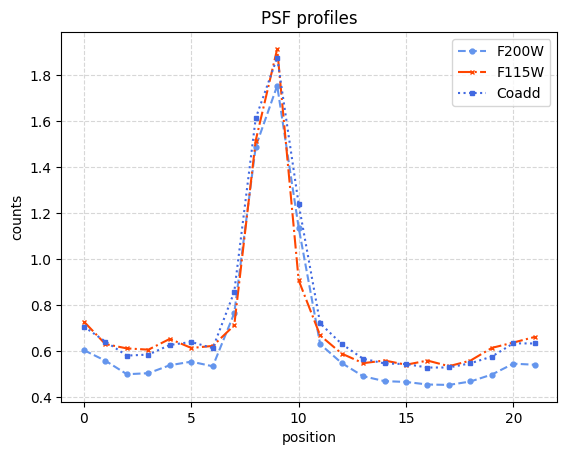

In [323]:
#check psf profile across images

idy1, idy2 = 9730, 9752
idx1 = 3983

# idy1, idy2 = 984, 1054
# idx1 = 1233

psf1 = im1['SCI'].data[idx1, idy1:idy2]
psf2 = im2['SCI'].data[idx1, idy1:idy2]
psf3 = im3['SCI'].data[idx1, idy1:idy2]
psf4 = im4['SCI'].data[idx1, idy1:idy2]
plt.plot(psf1, color = 'cornflowerblue', marker = 'o', ls = '--', markersize = 3.5, label = 'F200W')
plt.plot(psf2, color = 'orangered', marker = 'x', ls = '-.', markersize = 3.5, label = 'F115W')
# plt.plot(psf4, color = 'grey', marker = 'x', ls = '-.', markersize = 3.5, label = 'F150W')
plt.plot(psf3, color = 'royalblue', marker = 's', ls = ':', markersize = 3.5, label = 'Coadd')
plt.legend()
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('position')
plt.ylabel('counts')
# plt.yscale('log')
plt.title('PSF profiles')
# plt.xlim(15, 20)
# plt.xlim(31, 36)
plt.show()

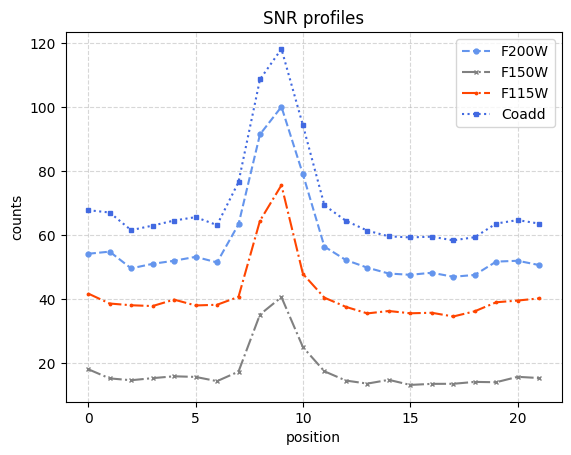

In [324]:
#check snr profile across images
snr1 = im1['SCI'].data[idx1, idy1:idy2]/im1['ERR'].data[idx1, idy1:idy2]
snr2 = im2['SCI'].data[idx1, idy1:idy2]/im2['ERR'].data[idx1, idy1:idy2]
snr3 = im3['SCI'].data[idx1, idy1:idy2]/im3['ERR'].data[idx1, idy1:idy2]
snr4 = im4['SCI'].data[idx1, idy1:idy2]/im4['ERR'].data[idx1, idy1:idy2]
plt.plot(snr1, color = 'cornflowerblue', marker = 'o', ls = '--', markersize = 3.5, label = 'F200W')
plt.plot(snr4, color = 'grey', marker = 'x', ls = '-.', markersize = 3.5, label = 'F150W')
plt.plot(snr2, color = 'orangered', marker = '.', ls = '-.', markersize = 3.5, label = 'F115W')
plt.plot(snr3, color = 'royalblue', marker = 's', ls = ':', markersize = 3.5, label = 'Coadd')
plt.legend()
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('position')
plt.ylabel('counts')
plt.title('SNR profiles')
# plt.xlim(15, 20)
# plt.xlim(31, 36)
# plt.yticks([20, 40, 60, 80, 100, 120])
plt.show()
# plt.savefig('snr_pf.png', bbox_inches = 'tight', dpi = 500)

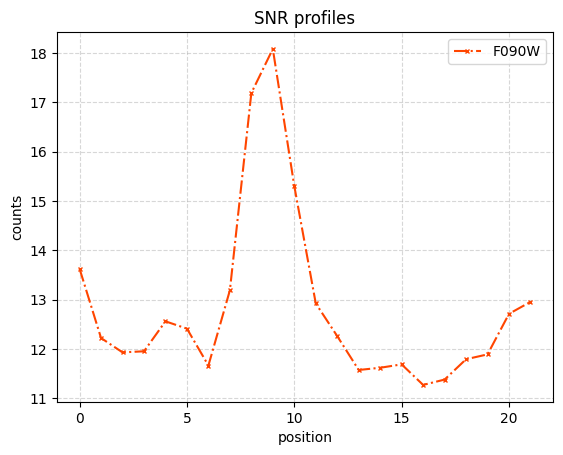

In [325]:
plt.plot(snr3 - snr1, color = 'orangered', marker = 'x', ls = '-.', markersize = 3.5, label = 'F090W')
plt.legend()
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('position')
plt.ylabel('counts')
plt.title('SNR profiles')
# plt.xlim(15, 20)
# plt.xlim(31, 36)
# plt.yticks([20, 40, 60, 80, 100, 120])
plt.show()

In [326]:
from jwst.datamodels import ImageModel

In [339]:
file = fits.open('jwstred_temp_dolphot/mosaic/f150w_i2d.fits')
repl = fits.open('jwstred_temp_dolphot/mosaic/f200w_i2d.fits')

In [340]:
file['PRIMARY'].header = repl['PRIMARY'].header
file['SCI'].header = repl['SCI'].header
file['ERR'].header = repl['ERR'].header
file['WHT'].header = repl['WHT'].header

file['SCI'].data = repl['SCI'].data
file['ERR'].data = repl['ERR'].data
file['WHT'].data = repl['WHT'].data

In [341]:
im = ImageModel(file)

In [342]:
im.to_fits('jwstred_temp_dolphot/mosaic/test_i2d.fits', overwrite = True)

In [343]:
from jhat import jwst_photclass

In [344]:
jwst_phot = jwst_photclass()
ref_image = 'jwstred_temp_dolphot/mosaic/test_i2d.fits'
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80,use_dq=True, SNR_min = 5)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_dolphot/mosaic/test_i2d.phot.txt


2025-02-11 00:19:03,470 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2025-02-11 00:19:04,450 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /Users/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2025-02-11 00:19:04,455 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /Users/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2025-02-11 00:19:04,455 - stpipe - INFO - Instrument: NIRCAM
2025-02-11 00:19:04,455 - stpipe - INFO - Detector: MULTIPLE
2025-02-11 00:19:04,456 - stpipe - INFO - Filter: F200W
2025-02-11 00:19:04,456 - stpipe - INFO - Pupil: CLEAR
2025-02-11 00:19:04,456 - stpipe - INFO - Subarray: FULL


dmag 0.2172
aper_sum_5.7px annulus_median_5.7px aper_bkg_5.7px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
     81.248275             0.499248      50.565779 ... -18.417227 -30.517141
     69.506647              0.48465      49.087292 ... -13.633019 -30.449663
      80.98556             0.518064      52.471566 ...   -18.6781 -30.401256
     108.22885             0.494003      50.034574 ... -13.821389 -30.351179
     65.936019             0.498482      50.488213 ...  -8.731822 -30.276278
     69.643136             0.477718      48.385191 ...  -9.570614 -30.039096
     61.435369             0.489043       49.53218 ... -16.404617 -29.992491
     86.009066             0.500098      50.651923 ...  -8.843723 -29.939497
     77.509341             0.492066      49.838411 ...  -0.369053 -29.807289
      62.44192             0.451428      45.722364 ... -12.368266  -29.73909
           ...                  ...            ... ...        ..

In [345]:
# refcat_coadd = refcat
# refcat_115 = refcat
# refcat_150 = refcat
refcat_200 = refcat

In [336]:
len(refcat_coadd)

259615

In [337]:
max(refcat_coadd['mag'])

28.291252

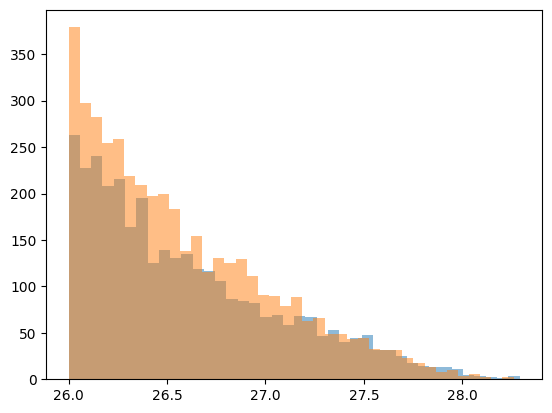

In [346]:
plt.hist(refcat_coadd['mag'][refcat_coadd['mag'] > 26], bins = 40, alpha = 0.5)
plt.hist(refcat_200['mag'][refcat_200['mag'] > 26], bins = 40, alpha = 0.5)
# plt.hist(refcat_150['mag'][refcat_150['mag'] > 26], bins = 40, alpha = 0.5)
# plt.hist(refcat_115['mag'][refcat_115['mag'] > 26], bins = 40, alpha = 0.5)
plt.show()

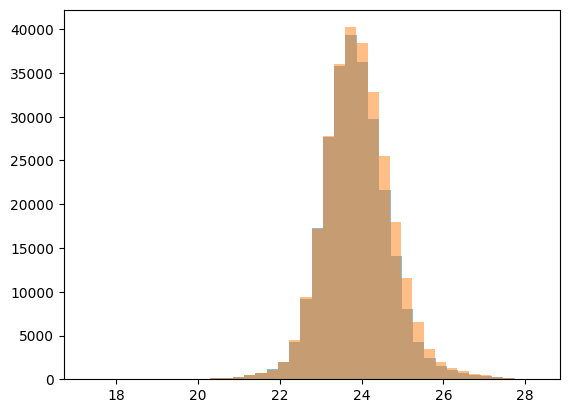

In [347]:
plt.hist(refcat_coadd['mag'], bins = 40, alpha = 0.5)
plt.hist(refcat_200['mag'], bins = 40, alpha = 0.5)
# plt.hist(refcat_150['mag'], bins = 40, alpha = 0.5)
# plt.hist(refcat_115['mag'], bins = 40, alpha = 0.5)
plt.show()

In [348]:
max(refcat_coadd['mag'])

28.291252

In [349]:
max(refcat_200['mag'])

28.260991

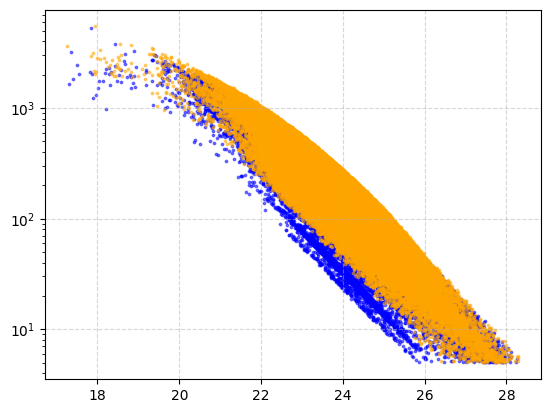

In [351]:
plt.scatter(refcat_200['mag'], 1.086/refcat_200['dmag'], s = 3.0, color = 'blue', alpha = 0.5)
plt.scatter(refcat_coadd['mag'], 1.086/refcat_coadd['dmag'], s = 3.0, color = 'orange', alpha = 0.5)
# plt.scatter(refcat_200['mag'], 1.086/refcat_200['dmag'], s = 3.0, color = 'blue', alpha = 0.5)
# plt.scatter(refcat_150['mag'], refcat_150['dmag'], s = 3.0, color = 'red', alpha = 0.5)
# plt.scatter(refcat_115['mag'], refcat_115['dmag'], s = 3.0, color = 'purple', alpha = 0.5)
# plt.xlim(27, 29)
# plt.ylim(0.2, 20)
plt.yscale('log')
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

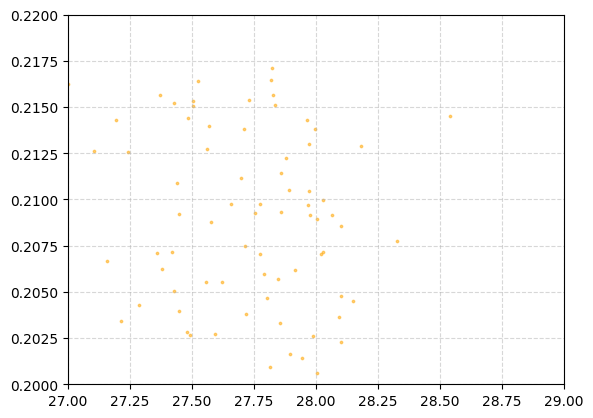

In [276]:
plt.scatter(refcat_coadd['mag'], refcat_coadd['dmag'], s = 3.0, color = 'orange', alpha = 0.5)
# plt.scatter(refcat_200['mag'], refcat_200['dmag'], s = 3.0, color = 'blue', alpha = 0.5)
# plt.scatter(refcat_150['mag'], refcat_150['dmag'], s = 3.0, color = 'red', alpha = 0.5)
# plt.scatter(refcat_115['mag'], refcat_115['dmag'], s = 3.0, color = 'purple', alpha = 0.5)
plt.xlim(27, 29)
plt.ylim(0.2, 0.22)
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

In [76]:
max(refcat_coadd['mag']), max(refcat_150['mag']), max(refcat_90['mag'])

(27.41346, 27.144359, 26.722868)

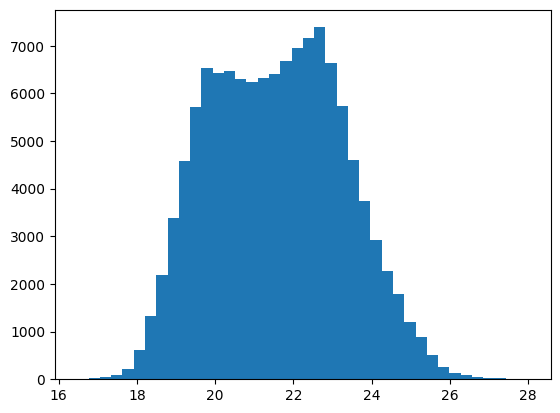

In [95]:
plt.hist(refcat_coadd['mag'], bins = 40)
plt.show()

In [108]:
snr_200 = np.exp(-refcat_200['mag']/2.5) / (np.exp(-refcat_200['mag']/2.5) - np.exp(-(refcat_200['mag'] + refcat_200['dmag'])/2.5))
# snr_200[snr_200 > 5000] = 1.0
snr_coadd = np.exp(-refcat_coadd['mag']/2.5) / (np.exp(-refcat_coadd['mag']/2.5) - np.exp(-(refcat_coadd['mag'] + refcat_coadd['dmag'])/2.5))

mag_200, mag_coadd = refcat_200['mag'], refcat_coadd['mag']
magerr_200, magerr_coadd = refcat_200['dmag'], refcat_coadd['dmag']

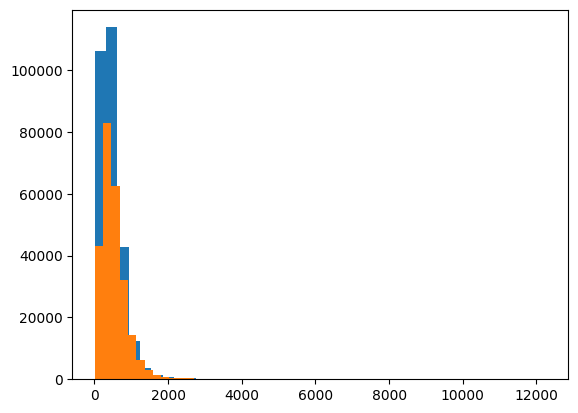

In [110]:
plt.hist(snr_200, bins = 40)
plt.hist(snr_coadd, bins = 40)
plt.show()

In [183]:
st = np.argsort(magerr_150)
stc = np.argsort(magerr_coadd)
# mst = np.argsort(mag_150[st][magerr_150[st] > 0.198])

In [186]:
mag_150[st][magerr_150[st] > 0.198][1], mag_coadd[stc][magerr_coadd[stc] > 0.198][1]

(26.271141, 27.322567)